Author: Lim Yu Cheng  

# References

tektronix, Programmatic-Control-Examples, Bench Scopes, Simple Plot Examples  
https://github.com/tektronix/Programmatic-Control-examples/blob/master/Examples/Oscilloscopes/BenchScopes/src/SimplePlotExample/tbs_simple_plot.py

## Import

In [3]:
version = '2'

#how many runs
runs = 100

# tbs simple plot
# python v3.x, pyvisa v1.8
# should work with TDS2k, TPS2k, and TBS1k series

# replaced 'wfmoutpre' with 'wfmpre' (see mdo simple plot)

import time # std module
import pyvisa as visa 
import matplotlib.pyplot as plt
import numpy as np 
from scipy import signal, stats, optimize, interpolate
from numpy.typing import NDArray
import ipywidgets as widgets


TEKTRONIX,TBS1072C,C026212,CF:91.1CT FV:v1.29.38; FPGA:v20.78; 



ACTION:
Connect probe to oscilloscope Channel 1 and the probe compensation signal.

Press Enter to continue...
 


autoset time: 1.6867278999998234 s
acquire time: 0.26339699999971344 s
transfer time: 0.019232900000133668 s
event status register: 0b00100000
all event messages: 113,"Undefined header; Command not found; CH1:probe ",113,"Undefined header; Command not found; CH2:probe "
transfer time: 0.017349599999761267 s
event status register: 0b00000000
all event messages: 0,"No events to report - queue empty"
acquire time: 0.1732899999997244 s
transfer time: 0.01910700000007637 s
event status register: 0b00000000
all event messages: 0,"No events to report - queue empty"
transfer time: 0.0174672000002829 s
event status register: 0b00000000
all event messages: 0,"No events to report - queue empty"
acquire time: 0.17432049999933952 s
transfer time: 0.019236500000261003 s
event status register: 0b00000000
all event messages: 0,"No events to report - queue empty"
transfer time: 0.017367599999488448 s
event status register: 0b00000000
all event messages: 0,"No events to report - queue empty"
acquire tim

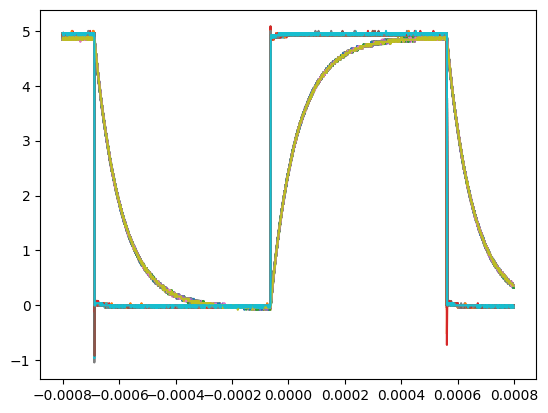

In [4]:
visa_address = 'USB0::0x0699::0x03C4::C026212::INSTR'

rm = visa.ResourceManager()
scope = rm.open_resource(visa_address)
scope.timeout = 20000 # ms
scope.encoding = 'latin_1'
scope.read_termination = '\n'
scope.write_termination = None
scope.write('*cls') # clear ESR

print(scope.query('*idn?'))

input("""
ACTION:
Connect probe to oscilloscope Channel 1 and the probe compensation signal.

Press Enter to continue...
""")

#scope.write('*rst') # reset
#t1 = time.perf_counter() #reset time
#r = scope.query('*opc?') # sync
#t2 = time.perf_counter()
#print('reset time: {} s'.format(t2 - t1))

scope.write('autoset EXECUTE') # autoset
t3 = time.perf_counter()
r = scope.query('*opc?') # sync
t4 = time.perf_counter()
print('autoset time: {} s'.format(t4 - t3))

# io config
scope.write('header 0')
scope.write('data:encdg RIBINARY')
scope.write('CH1:probe 1')
scope.write('CH1:scale 1')
scope.write('CH1:position 0')
scope.write('CH2:probe 1')
scope.write('CH2:scale 1')
scope.write('CH2:position 0')
scope.write('horizontal:main:scale 100E-6')
scope.write('data:start 1') # first sample
record = int(scope.query('wfmpre:nr_pt?'))
scope.write('data:stop {}'.format(record)) # last sample
scope.write('wfmpre:byt_nr 1') # 1 byte per sample




#data container
input_wave = np.zeros((runs,2000))
output_wave = np.zeros((runs,2000))
#filtered_wave = np.zeros((10,2300))

for i in range(0,runs):
    #get output
    # acq config
    scope.write('data:source CH1') # channel
    scope.write('acquire:state 0') # stop
    scope.write('acquire:stopafter SEQUENCE') # single
    scope.write('acquire:state 1') # run
    t5 = time.perf_counter()
    r = scope.query('*opc?') # sync
    t6 = time.perf_counter()
    print('acquire time: {} s'.format(t6 - t5))
    
    # data query
    t7 = time.perf_counter()
    bin_wave = scope.query_binary_values('curve?', datatype='b', container=np.array)
    t8 = time.perf_counter()
    print('transfer time: {} s'.format(t8 - t7))
    
    # retrieve scaling factors
    tscale = float(scope.query('wfmpre:xincr?'))
    tstart = float(scope.query('wfmpre:xzero?'))
    vscale = float(scope.query('wfmpre:ymult?')) # volts / level
    voff = float(scope.query('wfmpre:yzero?')) # reference voltage
    vpos = float(scope.query('wfmpre:yoff?')) # reference position (level)
    
    # error checking
    r = int(scope.query('*esr?'))
    print('event status register: 0b{:08b}'.format(r))
    r = scope.query('allev?').strip()
    print('all event messages: {}'.format(r))
    
    # create scaled vectors
    # horizontal (time)
    total_time = tscale * record
    tstop = tstart + total_time
    scaled_time = np.linspace(tstart, tstop, num=record, endpoint=False, dtype='double')
    # vertical (voltage)
    unscaled_wave = np.array(bin_wave, dtype='double') # data type conversion
    scaled_wave = (unscaled_wave - vpos) * vscale + voff

    #remove the oscillations
    #filtered_wave[i, 0:1200] = np.copy(scaled_wave[0:1200])
    #filtered_wave[i, 1200:2300] = np.copy(scaled_wave[1400:2500])

    output_wave[i] = np.copy(scaled_wave)
    
    #plotting
    #pl.step(scaled_time, scaled_wave)
    plt.plot(scaled_time, scaled_wave)
    # try removing plot.show to see its behaviour!
    #plt.show()




    ########################################################
    #Get input

    # data query
    scope.write('data:source CH2') # channel
    t7 = time.perf_counter()
    bin_wave = scope.query_binary_values('curve?', datatype='b', container=np.array)
    t8 = time.perf_counter()
    print('transfer time: {} s'.format(t8 - t7))
    
    # retrieve scaling factors
    tscale = float(scope.query('wfmpre:xincr?'))
    tstart = float(scope.query('wfmpre:xzero?'))
    vscale = float(scope.query('wfmpre:ymult?')) # volts / level
    voff = float(scope.query('wfmpre:yzero?')) # reference voltage
    vpos = float(scope.query('wfmpre:yoff?')) # reference position (level)
    
    # error checking
    r = int(scope.query('*esr?'))
    print('event status register: 0b{:08b}'.format(r))
    r = scope.query('allev?').strip()
    print('all event messages: {}'.format(r))
    
    # create scaled vectors
    # horizontal (time)
    total_time = tscale * record
    tstop = tstart + total_time
    scaled_time = np.linspace(tstart, tstop, num=record, endpoint=False, dtype='double')
    # vertical (voltage)
    unscaled_wave = np.array(bin_wave, dtype='double') # data type conversion
    scaled_wave = (unscaled_wave - vpos) * vscale + voff

    #remove the oscillations
    #filtered_wave[i, 0:1200] = np.copy(scaled_wave[0:1200])
    #filtered_wave[i, 1200:2300] = np.copy(scaled_wave[1400:2500])

    input_wave[i] = np.copy(scaled_wave)
    
    #plotting
    #pl.step(scaled_time, scaled_wave)
    plt.plot(scaled_time, scaled_wave)
    # try removing plot.show to see its behaviour!
    #plt.show()

np.savetxt('time_'+version+'.txt', scaled_time)
np.savetxt('output_'+version+'.txt', output_wave)
np.savetxt('input_'+version+'.txt', input_wave)


scope.close()
rm.close()
    
print("\nend of demonstration")
